In [3]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
palette = sns.color_palette('deep', 5)
palette[1], palette[2] = palette[2], palette[1]
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Helper Functions

In [4]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = full_df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [5]:
train_df = pd.read_csv('./input/train.csv')
shot_fixed = pd.read_csv('./input/shots_fixed.csv')
val_df = pd.read_csv('./input/val.csv')

shot_fixed = shot_fixed.drop(['GRID_TYPE'], 1)

train_df = train_df.append(shot_fixed, ignore_index=True)

In [433]:
train_df

,ACTION_TYPE,EVENTTIME,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Layup Shot,574,Made Shot,20151121,247,21500192,DET,-193.5643,150.6232,9,...,0,1,564.22,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612764,Washington Wizards,WAS
1,Driving Floating Jump Shot,144,Made Shot,20151203,329,21500280,MEM,-46.5642,6.6503,2,...,4,1,164.05,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612759,San Antonio Spurs,SAS
2,Tip Layup Shot,497,Missed Shot,20160104,444,21500513,BKN,-15.1508,102.5798,8,...,1,0,483.30,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,BOS
3,Dunk Shot,283,Made Shot,20151109,66,21500102,DEN,-4.5942,59.7122,4,...,0,1,298.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612743,Denver Nuggets,POR
4,Jump Shot,681,Missed Shot,20151127,8,21500227,CHA,-39.3202,67.6151,11,...,6,0,683.49,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612766,Charlotte Hornets,CLE
5,Jump Shot,357,Missed Shot,20151114,346,21500139,WAS,-54.3030,191.0606,5,...,25,0,325.95,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,1610612764,Washington Wizards,ORL
6,Jump Shot,263,Made Shot,20160109,509,21500556,SAC,23.2629,252.9521,4,...,23,1,253.68,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,1610612744,Golden State Warriors,GSW
7,Jump Shot,629,Made Shot,20151205,432,21500293,HOU,-112.6102,144.8647,10,...,21,1,615.59,2PT Field Goal,Left Side(L),Mid-Range,16-24 ft.,1610612745,Houston Rockets,SAC
8,Jump Shot,36,Made Shot,20151229,479,21500469,NYK,-202.4811,151.6097,0,...,22,1,70.00,3PT Field Goal,Right Side(R),Right Corner 3,24+ ft.,1610612752,New York Knicks,DET
9,Driving Floating Bank Jump Shot,24,Made Shot,20151120,472,21500188,LAL,134.5107,51.9049,0,...,5,1,26.40,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612761,Toronto Raptors,TOR


In [434]:
val_df

,ACTION_TYPE,EVENTTIME,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Turnaround Bank shot,270,Made Shot,20160123,82,21500661,DEN,-45.7696,59.2846,4,...,7,1,274.74,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612743,Denver Nuggets,DET
1,Driving Hook Shot,312,Made Shot,20151114,330,21500142,SAS,-23.4466,84.6161,5,...,6,1,316.28,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612759,San Antonio Spurs,PHI
2,Running Layup Shot,91,Made Shot,20151104,258,21500068,UTA,10.4035,81.3721,1,...,1,1,94.83,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612762,Utah Jazz,POR
3,Jump Shot,569,Made Shot,20151202,164,21500274,HOU,-126.5095,227.6582,9,...,25,1,571.76,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets,NOP
4,Layup Shot,357,Missed Shot,20151202,68,21500270,DET,-189.8915,150.3355,5,...,0,0,346.79,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612756,Phoenix Suns,PHX
5,Reverse Layup Shot,47,Missed Shot,20151223,96,21500433,PHX,225.6904,4.8465,0,...,0,0,41.33,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612756,Phoenix Suns,DEN
6,Turnaround Fadeaway shot,594,Missed Shot,20151111,447,21500119,HOU,99.8651,163.5877,9,...,11,0,612.78,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612745,Houston Rockets,BKN
7,Jump Shot,83,Missed Shot,20151030,109,21500025,DET,-5.6044,253.9949,1,...,24,0,88.77,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612765,Detroit Pistons,CHI
8,Layup Shot,661,Missed Shot,20151130,379,21500259,UTA,-176.7198,49.3548,11,...,2,0,686.59,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612762,Utah Jazz,GSW
9,Jump Shot,263,Made Shot,20151229,56,21500469,NYK,201.1269,126.9807,4,...,23,1,300.26,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,1610612752,New York Knicks,DET


In [435]:
print(train_df.info())
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128812 entries, 0 to 128811
Data columns (total 26 columns):
ACTION_TYPE            128812 non-null object
EVENTTIME              128812 non-null int64
EVENT_TYPE             128812 non-null object
GAME_DATE              128812 non-null int64
GAME_EVENT_ID          128812 non-null int64
GAME_ID                128812 non-null int64
HTM                    128812 non-null object
LOC_X                  128812 non-null float64
LOC_Y                  128812 non-null float64
MINUTES_REMAINING      128812 non-null int64
PERIOD                 128812 non-null int64
PLAYER_ID              128812 non-null int64
PLAYER_NAME            128812 non-null object
QUARTER                128812 non-null float64
SECONDS_REMAINING      128812 non-null int64
SHOT_ATTEMPTED_FLAG    128812 non-null int64
SHOT_DISTANCE          128812 non-null int64
SHOT_MADE_FLAG         128812 non-null int64
SHOT_TIME              128812 non-null float64
SHOT_TYPE             

,EVENTTIME,GAME_DATE,GAME_EVENT_ID,GAME_ID,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,QUARTER,SECONDS_REMAINING,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,TEAM_ID
count,128812.000000,1.288120e+05,128812.000000,1.288120e+05,128812.000000,128812.000000,128812.000000,128812.000000,1.288120e+05,128812.000000,128812.000000,128812.0,128812.000000,128812.000000,128812.000000,1.288120e+05
mean,351.568138,2.015325e+07,255.563760,2.150032e+07,-2.612137,126.164847,5.378645,2.476702,2.428969e+05,2.476687,28.849447,1.0,12.446829,0.448778,353.862225,1.610613e+09
std,206.932586,3.787449e+03,159.061275,1.864307e+02,129.108526,88.895848,3.439298,1.137799,3.314249e+05,1.137792,17.382799,0.0,9.848218,0.497371,207.039438,8.661184e+00
min,0.000000,2.015103e+07,2.000000,2.150000e+07,-278.099800,-100.652600,0.000000,1.000000,7.080000e+02,1.000000,0.000000,1.0,0.000000,0.000000,0.400000,1.610613e+09
25%,173.000000,2.015112e+07,116.000000,2.150016e+07,-102.925600,47.621000,2.000000,1.000000,2.011440e+05,1.000000,14.000000,1.0,2.000000,0.000000,175.670000,1.610613e+09
50%,352.000000,2.015121e+07,254.000000,2.150033e+07,-1.959700,126.490500,5.000000,2.000000,2.023280e+05,2.000000,29.000000,1.0,13.000000,0.000000,355.060000,1.610613e+09
75%,531.000000,2.015123e+07,388.000000,2.150048e+07,96.272475,198.579000,8.000000,3.000000,2.031380e+05,3.000000,44.000000,1.0,23.000000,1.000000,533.270000,1.610613e+09
max,720.000000,2.016012e+07,729.000000,2.150066e+07,281.119000,422.487100,12.000000,6.000000,1.626273e+06,6.000000,59.000000,1.0,85.000000,1.000000,719.990000,1.610613e+09


In [436]:
print(val_df.info())
val_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9502 entries, 0 to 9501
Data columns (total 26 columns):
ACTION_TYPE            9502 non-null object
EVENTTIME              9502 non-null int64
EVENT_TYPE             9502 non-null object
GAME_DATE              9502 non-null int64
GAME_EVENT_ID          9502 non-null int64
GAME_ID                9502 non-null int64
HTM                    9502 non-null object
LOC_X                  9502 non-null float64
LOC_Y                  9502 non-null float64
MINUTES_REMAINING      9502 non-null int64
PERIOD                 9502 non-null int64
PLAYER_ID              9502 non-null int64
PLAYER_NAME            9502 non-null object
QUARTER                9502 non-null float64
SECONDS_REMAINING      9502 non-null int64
SHOT_ATTEMPTED_FLAG    9502 non-null int64
SHOT_DISTANCE          9502 non-null int64
SHOT_MADE_FLAG         9502 non-null int64
SHOT_TIME              9502 non-null float64
SHOT_TYPE              9502 non-null object
SHOT_ZONE_AREA      

,EVENTTIME,GAME_DATE,GAME_EVENT_ID,GAME_ID,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,QUARTER,SECONDS_REMAINING,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,TEAM_ID
count,9502.000000,9.502000e+03,9502.000000,9.502000e+03,9502.000000,9502.000000,9502.000000,9502.000000,9.502000e+03,9502.000000,9502.000000,9502.0,9502.000000,9502.000000,9502.000000,9.502000e+03
mean,350.456746,2.015323e+07,253.664071,2.150032e+07,-3.074471,124.926204,5.357398,2.460535,2.415425e+05,2.460640,29.012839,1.0,12.421806,0.453378,352.800872,1.610613e+09
std,208.011587,3.777252e+03,159.544522,1.866929e+02,129.572251,88.998844,3.458419,1.141532,3.287737e+05,1.141443,17.417484,0.0,9.881710,0.497848,208.112002,8.642080e+00
min,0.000000,2.015103e+07,2.000000,2.150000e+07,-250.945200,-90.553800,0.000000,1.000000,7.080000e+02,1.000000,0.000000,1.0,0.000000,0.000000,0.410000,1.610613e+09
25%,170.000000,2.015112e+07,112.000000,2.150016e+07,-103.794300,45.666000,2.000000,1.000000,2.011440e+05,1.000000,14.000000,1.0,2.000000,0.000000,172.012500,1.610613e+09
50%,352.000000,2.015121e+07,251.000000,2.150032e+07,-1.616000,124.065650,5.000000,2.000000,2.023280e+05,2.000000,29.000000,1.0,13.000000,0.000000,354.700000,1.610613e+09
75%,535.000000,2.015123e+07,387.000000,2.150048e+07,95.350725,198.099400,8.000000,3.000000,2.031150e+05,3.000000,44.000000,1.0,23.000000,1.000000,535.162500,1.610613e+09
max,714.000000,2.016012e+07,693.000000,2.150066e+07,275.679300,422.245700,11.000000,6.000000,1.626273e+06,6.000000,59.000000,1.0,83.000000,1.000000,719.620000,1.610613e+09


In [437]:
full_df = train_df.append(val_df, ignore_index=True)

# nba = full_df[ :128820 ]

del train_df , val_df

print ('Datasets:' , 'full_df:' , full_df.shape)

Datasets: full_df: (138314, 26)


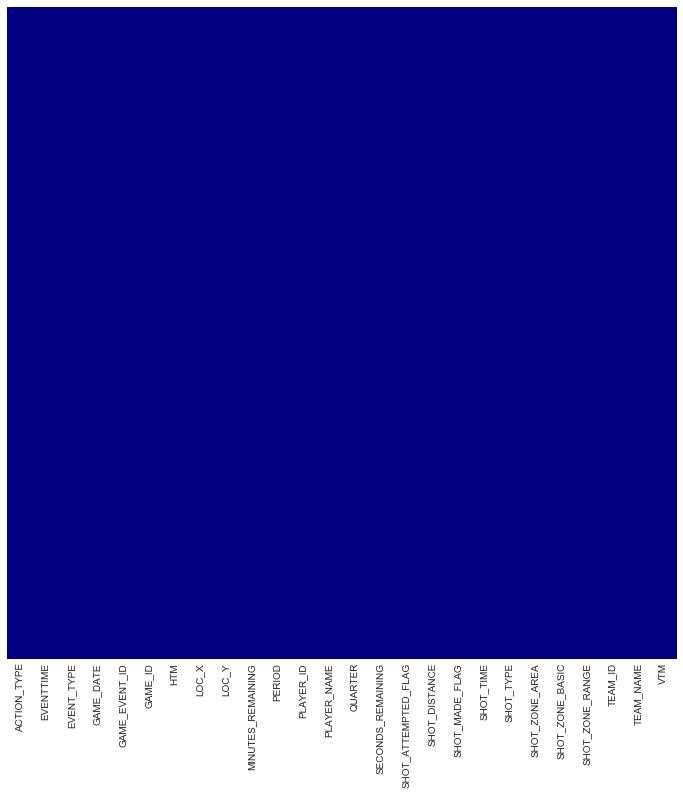

In [438]:
plt.figure(figsize=(12, 12))
sns.heatmap(full_df.isnull(), yticklabels=False, cbar=False, cmap='jet')

In [439]:
toDrop = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_NAME', 'SHOT_ATTEMPTED_FLAG', 'GAME_DATE']
full_df = full_df.drop(toDrop, 1)
full_df.head()

,ACTION_TYPE,EVENTTIME,EVENT_TYPE,GAME_EVENT_ID,GAME_ID,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,...,SECONDS_REMAINING,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,VTM
0,Layup Shot,574,Made Shot,247,21500192,DET,-193.5643,150.6232,9,3,...,34,0,1,564.22,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612764,WAS
1,Driving Floating Jump Shot,144,Made Shot,329,21500280,MEM,-46.5642,6.6503,2,3,...,24,4,1,164.05,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612759,SAS
2,Tip Layup Shot,497,Missed Shot,444,21500513,BKN,-15.1508,102.5798,8,4,...,17,1,0,483.30,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,BOS
3,Dunk Shot,283,Made Shot,66,21500102,DEN,-4.5942,59.7122,4,1,...,43,0,1,298.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612743,POR
4,Jump Shot,681,Missed Shot,8,21500227,CHA,-39.3202,67.6151,11,1,...,21,6,0,683.49,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612766,CLE


In [440]:
full_df.describe()

,EVENTTIME,GAME_EVENT_ID,GAME_ID,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,QUARTER,SECONDS_REMAINING,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,TEAM_ID
count,138314.000000,138314.000000,1.383140e+05,138314.000000,138314.000000,138314.000000,138314.000000,138314.000000,138314.000000,138314.000000,138314.000000,138314.000000,1.383140e+05
mean,351.491787,255.433253,2.150032e+07,-2.643899,126.079753,5.377185,2.475592,2.475585,28.860672,12.445110,0.449094,353.789311,1.610613e+09
std,207.006328,159.094668,1.864486e+02,129.140020,88.903157,3.440607,1.138059,1.138046,17.385170,9.850489,0.497404,207.112718,8.659872e+00
min,0.000000,2.000000,2.150000e+07,-278.099800,-100.652600,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.400000,1.610613e+09
25%,173.000000,116.000000,2.150016e+07,-102.989900,47.521100,2.000000,1.000000,1.000000,14.000000,2.000000,0.000000,175.510000,1.610613e+09
50%,352.000000,254.000000,2.150033e+07,-1.946300,126.294500,5.000000,2.000000,2.000000,29.000000,13.000000,0.000000,355.045000,1.610613e+09
75%,531.000000,388.000000,2.150048e+07,96.208400,198.543000,8.000000,3.000000,3.000000,44.000000,23.000000,1.000000,533.420000,1.610613e+09
max,720.000000,729.000000,2.150066e+07,281.119000,422.487100,12.000000,6.000000,6.000000,59.000000,85.000000,1.000000,719.990000,1.610613e+09


In [441]:
full_df['DIST'] = np.sqrt(full_df['LOC_X'] ** 2 + full_df['LOC_Y'] ** 2)

LOC_X_ZERO = full_df['LOC_X'] == 0
full_df['ANGLE'] = np.array([0] * len(full_df))
full_df['ANGLE'][~LOC_X_ZERO] = np.arctan(full_df['LOC_Y'][~LOC_X_ZERO] / full_df['LOC_X'][~LOC_X_ZERO])
full_df['ANGLE'][LOC_X_ZERO] = np.pi / 2 

full_df['REMAINING_TIME'] = full_df['MINUTES_REMAINING'] * 60 + full_df['SECONDS_REMAINING']

C:\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [442]:
full_df.head()

,ACTION_TYPE,EVENTTIME,EVENT_TYPE,GAME_EVENT_ID,GAME_ID,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,...,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,VTM,DIST,ANGLE,REMAINING_TIME
0,Layup Shot,574,Made Shot,247,21500192,DET,-193.5643,150.6232,9,3,...,564.22,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612764,WAS,245.264116,-0.661279,574
1,Driving Floating Jump Shot,144,Made Shot,329,21500280,MEM,-46.5642,6.6503,2,3,...,164.05,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612759,SAS,47.036701,-0.141861,144
2,Tip Layup Shot,497,Missed Shot,444,21500513,BKN,-15.1508,102.5798,8,4,...,483.30,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,BOS,103.692633,-1.424159,497
3,Dunk Shot,283,Made Shot,66,21500102,DEN,-4.5942,59.7122,4,1,...,298.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612743,POR,59.888676,-1.494009,283
4,Jump Shot,681,Missed Shot,8,21500227,CHA,-39.3202,67.6151,11,1,...,683.49,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612766,CLE,78.216877,-1.044069,681


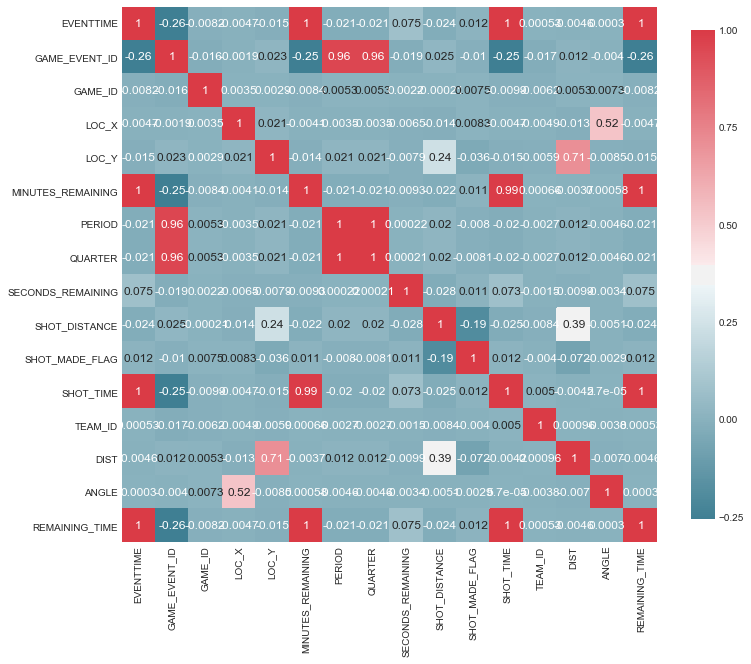

In [443]:
plot_correlation_map( full_df )

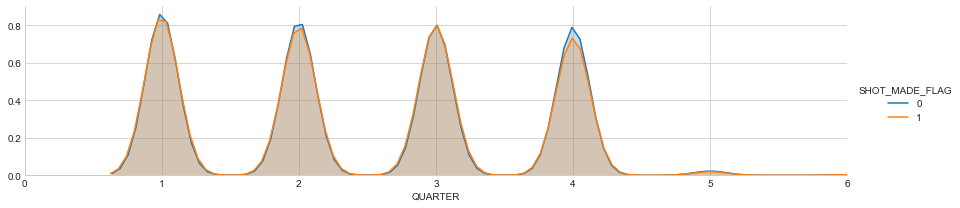

In [444]:
plot_distribution( full_df , var = 'QUARTER' , target = 'SHOT_MADE_FLAG' )

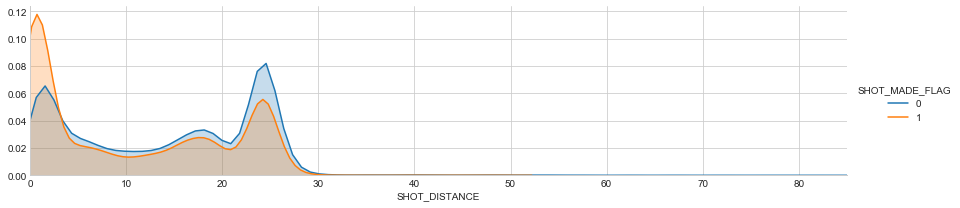

In [445]:
plot_distribution( full_df , var = 'SHOT_DISTANCE' , target = 'SHOT_MADE_FLAG' )

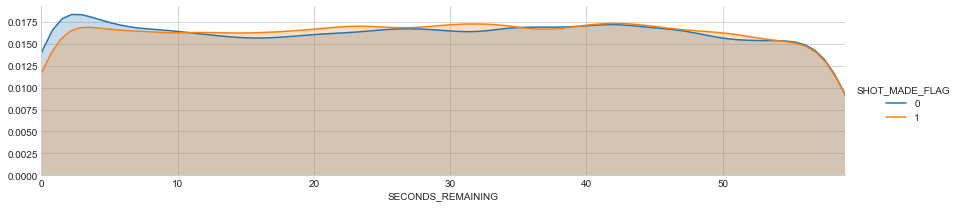

In [446]:
plot_distribution( full_df , var = 'SECONDS_REMAINING' , target = 'SHOT_MADE_FLAG' )

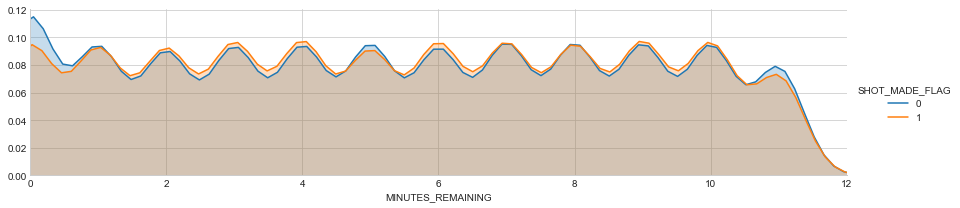

In [447]:
plot_distribution( full_df , var = 'MINUTES_REMAINING' , target = 'SHOT_MADE_FLAG' )

C:\Python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


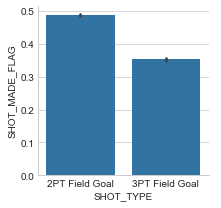

In [448]:
plot_categories( full_df , cat = 'SHOT_TYPE' , target = 'SHOT_MADE_FLAG' )

C:\Python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


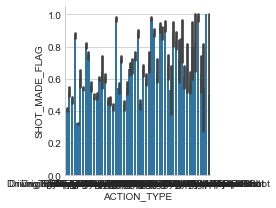

In [449]:
plot_categories( full_df , cat = 'ACTION_TYPE' , target = 'SHOT_MADE_FLAG' )

C:\Python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


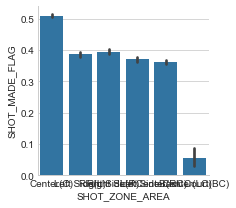

In [450]:
plot_categories( full_df , cat = 'SHOT_ZONE_AREA' , target = 'SHOT_MADE_FLAG' )

C:\Python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


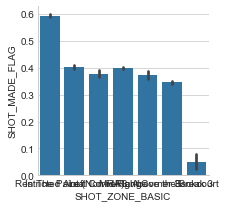

In [451]:
plot_categories( full_df , cat = 'SHOT_ZONE_BASIC' , target = 'SHOT_MADE_FLAG' )

C:\Python36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


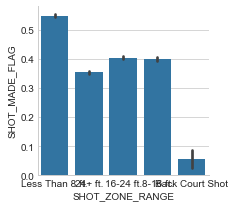

In [452]:
plot_categories( full_df , cat = 'SHOT_ZONE_RANGE' , target = 'SHOT_MADE_FLAG' )

In [453]:
full_df['SHOT_ZONE_BASIC'] = full_df['SHOT_ZONE_BASIC'].map( {'Above the Break 3': 0, 'Backcourt': 1, 'In The Paint (Non-RA)': 2, 'Left Corner 3': 3, 'Mid-Range': 4, 'Restricted Area': 5, 'Right Corner 3': 6} ).astype(int)

shotZoneBasic = pd.get_dummies( full_df.SHOT_ZONE_BASIC , prefix='SZB' )
shotZoneBasic.head()

,SZB_0,SZB_1,SZB_2,SZB_3,SZB_4,SZB_5,SZB_6
0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0


In [454]:
full_df['SHOT_ZONE_RANGE'] = full_df['SHOT_ZONE_RANGE'].map( {'16-24 ft.': 0, '24+ ft.': 1, '8-16 ft.': 2, 'Back Court Shot': 3, 'Less Than 8 ft.': 4} ).astype(int)

shotZoneRange = pd.get_dummies( full_df.SHOT_ZONE_RANGE , prefix='SZR' )
shotZoneRange.head()

,SZR_0,SZR_1,SZR_2,SZR_3,SZR_4
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [455]:
full_df['SHOT_ZONE_AREA'] = full_df['SHOT_ZONE_AREA'].map( {'Back Court(BC)': 0, 'Center(C)': 1, 'Left Side Center(LC)': 2, 'Left Side(L)': 3, 'Right Side Center(RC)': 4, 'Right Side(R)': 5} ).astype(int)

shotZoneArea = pd.get_dummies( full_df.SHOT_ZONE_AREA , prefix='SZA' )
shotZoneArea.head()

,SZA_0,SZA_1,SZA_2,SZA_3,SZA_4,SZA_5
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [456]:
quarter = pd.get_dummies( full_df.QUARTER , prefix='Q' )
quarter.head()

,Q_1.0,Q_2.0,Q_3.0,Q_4.0,Q_5.0,Q_6.0
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [457]:
teamId = pd.get_dummies( full_df.TEAM_ID , prefix='TI_' )
teamId.head()

,TI__1610612737,TI__1610612738,TI__1610612739,TI__1610612740,TI__1610612741,TI__1610612742,TI__1610612743,TI__1610612744,TI__1610612745,TI__1610612746,...,TI__1610612757,TI__1610612758,TI__1610612759,TI__1610612760,TI__1610612761,TI__1610612762,TI__1610612763,TI__1610612764,TI__1610612765,TI__1610612766
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [458]:
shotDistance = full_df.SHOT_DISTANCE

gameEventId = full_df.GAME_EVENT_ID

secondsRemaining = full_df.SECONDS_REMAINING
minutesRemaining = full_df.MINUTES_REMAINING
shotMadeFlag = full_df.SHOT_MADE_FLAG

full_df_X = pd.concat([gameEventId, shotZoneBasic, shotZoneRange, shotZoneArea, quarter, shotDistance, full_df['REMAINING_TIME'], full_df['ANGLE']], axis=1)
full_df_X.head()

,GAME_EVENT_ID,SZB_0,SZB_1,SZB_2,SZB_3,SZB_4,SZB_5,SZB_6,SZR_0,SZR_1,...,SZA_5,Q_1.0,Q_2.0,Q_3.0,Q_4.0,Q_5.0,Q_6.0,SHOT_DISTANCE,REMAINING_TIME,ANGLE
0,247,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,574,-0.661279
1,329,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,4,144,-0.141861
2,444,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,497,-1.424159
3,66,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,283,-1.494009
4,8,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,6,681,-1.044069


In [459]:
# train_valid_X = full_df_X[0:128820]
# train_valid_y = nba.SHOT_MADE_FLAG

# test_X = full_df_X[128820:]

# train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size=0.7)

# print (full_df_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

X = full_df_X
y = full_df.SHOT_MADE_FLAG

train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size=0.7)

print (full_df_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(138314, 28) (96819, 28) (41495, 28) (96819,) (41495,) (9494, 56)


C:\Python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


1.0


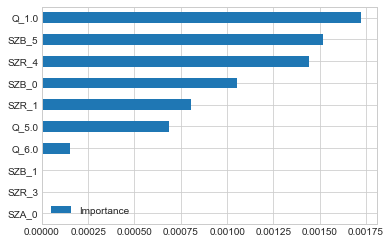

In [460]:
plot_variable_importance(train_X, train_y)

# Random Forest Classifier

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [461]:
model_rfc = RandomForestClassifier(n_estimators=70, max_depth=8)
model_rfc.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [462]:
print (model_rfc.score( train_X , train_y ) , model_rfc.score( valid_X , valid_y ))

0.622687695597 0.62255693457


# Gradient Boosting Classifier

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [463]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(train_X, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [464]:
print (model_gbc.score( train_X , train_y ) , model_gbc.score( valid_X , valid_y ))

0.623038866338 0.624099289071


# K-nearest neighbors

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [465]:
model_knn = KNeighborsClassifier(n_neighbors = 3)
model_knn.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [466]:
print (model_knn.score( train_X , train_y ) , model_knn.score( valid_X , valid_y ))

0.853820014667 0.612387034582


# Gaussian Naive Bayes

https://machinelearningmastery.com/naive-bayes-for-machine-learning/

In [467]:
model_gnb = GaussianNB()
model_gnb.fit(train_X, train_y)

GaussianNB(priors=None)

In [468]:
print (model_gnb.score( train_X , train_y ) , model_gnb.score( valid_X , valid_y ))

0.477561222487 0.473864321003


# Logistic Regression

https://machinelearningmastery.com/naive-bayes-for-machine-learning/

In [469]:
model_lr = GaussianNB()
model_lr.fit(train_X, train_y)

GaussianNB(priors=None)

In [470]:
print (model_lr.score( train_X , train_y ) , model_lr.score( valid_X , valid_y ))

0.477561222487 0.473864321003


# SVM

http://scikit-learn.org/stable/modules/svm.html

In [471]:
# model_svc = SVC()
# model_svc.fit(train_X, train_y)

In [472]:
# print (model_svc.score( train_X , train_y ) , model_svc.score( valid_X , valid_y ))

# Log Loss

http://wiki.fast.ai/index.php/Log_Loss

In [473]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1 - epsilon, pred)
    ll = sum(act * sp.log(pred) + sp.subtract(1,act) * sp.log(sp.subtract(1, pred)))
    ll = ll * -1.0 / len(act)
    return ll

# Finding Best Model by Cross-Validation
http://scikit-learn.org/stable/modules/cross_validation.html

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
import time


# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RFC...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("# of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    for train_k, test_k in KFold(len(train_X), n_folds=10, shuffle=True):
        rfc.fit(train_X.iloc[train_k], train_y.iloc[train_k])
        pred = rfc.predict(train_X.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Finished {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RFC...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("Max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    for train_k, test_k in KFold(len(train_X), n_folds=10, shuffle=True):
        rfc.fit(train_X.iloc[train_k], train_y.iloc[train_k])
        pred = rfc.predict(train_X.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Finished {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RFC...


C:\Python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'np' is not defined

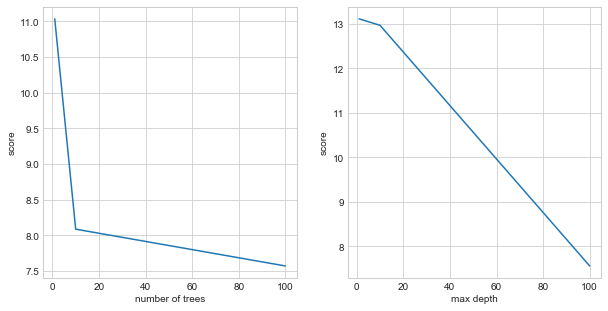

In [475]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

# Build the model

In [476]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train_X, train_y)
print (model_gbc.score( train_X , train_y ) , model_gbc.score( valid_X , valid_y ))

0.623038866338 0.624099289071


# Test

In [477]:
test_Y = model.predict( valid_X )

print(classification_report(valid_y, test_Y))
print("Accuracy: {}".format(accuracy_score(valid_y, test_Y)))

GAME_EVENT_ID = valid_X.GAME_EVENT_ID
test = pd.DataFrame( { 'GAME_EVENT_ID': GAME_EVENT_ID , 'SHOT_MADE_FLAG': test_Y } )
test.shape
test.head()
test.to_csv( 'pred.csv' , index = False )

             precision    recall  f1-score   support

          0       0.81      0.85      0.83     22947
          1       0.80      0.75      0.78     18548

avg / total       0.81      0.81      0.81     41495

Accuracy: 0.8064345101819497


# To Hand In

In [478]:
soln = train_df = pd.read_csv('../input/solution_no_answer.csv')

soln['DIST'] = np.sqrt(soln['LOC_X'] ** 2 + soln['LOC_Y'] ** 2)

LOC_X_ZERO = soln['LOC_X'] == 0
soln['ANGLE'] = np.array([0] * len(soln))
soln['ANGLE'][~LOC_X_ZERO] = np.arctan(soln['LOC_Y'][~LOC_X_ZERO] / soln['LOC_X'][~LOC_X_ZERO])
soln['ANGLE'][LOC_X_ZERO] = np.pi / 2 

soln['REMAINING_TIME'] = soln['MINUTES_REMAINING'] * 60 + soln['SECONDS_REMAINING']

soln['SHOT_ZONE_BASIC'] = soln['SHOT_ZONE_BASIC'].map( {'Above the Break 3': 0, 'Backcourt': 1, 'In The Paint (Non-RA)': 2, 'Left Corner 3': 3, 'Mid-Range': 4, 'Restricted Area': 5, 'Right Corner 3': 6} ).astype(int)
shotZoneBasic = pd.get_dummies( soln.SHOT_ZONE_BASIC , prefix='SZB' )

soln['SHOT_ZONE_RANGE'] = soln['SHOT_ZONE_RANGE'].map( {'16-24 ft.': 0, '24+ ft.': 1, '8-16 ft.': 2, 'Back Court Shot': 3, 'Less Than 8 ft.': 4} ).astype(int)
shotZoneRange = pd.get_dummies( soln.SHOT_ZONE_RANGE , prefix='SZR' )

soln['SHOT_ZONE_AREA'] = soln['SHOT_ZONE_AREA'].map( {'Back Court(BC)': 0, 'Center(C)': 1, 'Left Side Center(LC)': 2, 'Left Side(L)': 3, 'Right Side Center(RC)': 4, 'Right Side(R)': 5} ).astype(int)
shotZoneArea = pd.get_dummies( soln.SHOT_ZONE_AREA , prefix='SZA' )

teamId = pd.get_dummies( soln.TEAM_ID , prefix='TI_' )

quarter = pd.get_dummies( soln.QUARTER , prefix='Q' )

toDrop = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_NAME', 'SHOT_ATTEMPTED_FLAG', 'GAME_DATE']
soln = soln.drop(toDrop, 1)

gameEventId = soln.GAME_EVENT_ID

shotDistance = soln.SHOT_DISTANCE
secondsRemaining = full_df.SECONDS_REMAINING
minutesRemaining = full_df.MINUTES_REMAINING

soln_X = pd.concat([gameEventId, shotZoneBasic, shotZoneRange, shotZoneArea, quarter, shotDistance, full_df['REMAINING_TIME'], full_df['ANGLE']], axis=1)

soln_X.head()

C:\Python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,GAME_EVENT_ID,SZB_0,SZB_1,SZB_2,SZB_3,SZB_4,SZB_5,SZB_6,SZR_0,SZR_1,...,SZA_5,Q_1.0,Q_2.0,Q_3.0,Q_4.0,Q_5.0,Q_6.0,SHOT_DISTANCE,REMAINING_TIME,ANGLE
0,3507.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,574,-0.661279
1,1906.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,144,-0.141861
2,5252.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,497,-1.424159
3,4854.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,283,-1.494009
4,6269.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,681,-1.044069


In [483]:
print(soln_X.head())

prediction = model.predict( soln_X.fillna(soln_X.mean(), inplace=True) )
GAME_EVENT_ID = soln_X.GAME_EVENT_ID.astype(int)
test = pd.DataFrame( { 'GAME_EVENT_ID': GAME_EVENT_ID , 'SHOT_MADE_FLAG': prediction } )
test.shape
test.head()
test = test[0:9503]
test.to_csv( 'test_submission.csv' , index = False )

   GAME_EVENT_ID  SZB_0  SZB_1  SZB_2  SZB_3  SZB_4  SZB_5  SZB_6  SZR_0  \
0         3507.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
1         1906.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
2         5252.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3         4854.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
4         6269.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0   

   SZR_1    ...     SZA_5  Q_1.0  Q_2.0  Q_3.0  Q_4.0  Q_5.0  Q_6.0  \
0    0.0    ...       0.0    0.0    0.0    0.0    1.0    0.0    0.0   
1    0.0    ...       0.0    0.0    0.0    1.0    0.0    0.0    0.0   
2    0.0    ...       0.0    0.0    1.0    0.0    0.0    0.0    0.0   
3    0.0    ...       0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4    0.0    ...       0.0    1.0    0.0    0.0    0.0    0.0    0.0   

   SHOT_DISTANCE  REMAINING_TIME     ANGLE  
0            2.0             574 -0.661279  
1            2.0          